# Import Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Others
import os

# Load Dataset

In [2]:
os.getcwd()

'/home/afsharino/Desktop/DataTalksClub/mlops-zoomcamp/01. Intro/src'

In [3]:
df = pd.read_parquet(r'../dataset/yellow_tripdata_2023-01.parquet')

# Data Exploration

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

# Question 1

In [8]:
print(f"There are {df.columns.shape[0]} Columns in January dataset")

There are 20 Columns in January dataset


# Question 2

In [7]:
# compute duration
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda time_delta: time_delta.total_seconds()/60)

In [9]:
print(f"The Standard Deviation of the trips duration in January is {df.duration.std()}")

The Standard Deviation of the trips duration in January is 42.594351241920904


# Question 3

<Axes: >

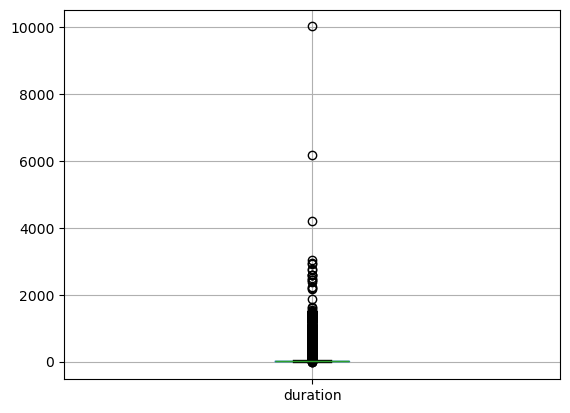

In [10]:
df.boxplot(column="duration")

In [12]:
total_records = df.shape[0]

In [13]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [14]:
records_after_drop = df.shape[0]

In [15]:
records_after_drop * 100 / total_records

98.1220282212598

# Question 4

In [16]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [17]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [18]:
print(f"Dimentionality of the feature matrix is {X_train.shape[1]}.")

Dimentionality of the feature matrix is 516.


# Question 5

In [19]:
target = 'duration'
y_train = df[target].values

model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

TypeError: got an unexpected keyword argument 'squared'

# Question 6

In [ ]:
def read_dataframe(path):
    df = pd.read_parquet(path)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [ ]:
df_train = read_dataframe(r'../dataset/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe(r'../dataset/yellow_tripdata_2023-02.parquet')

In [ ]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [ ]:
categorical = ['PU_DO'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [ ]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)